In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import pickle
from tqdm.notebook import tqdm

from collections import Counter

In [2]:
# I retrieve the dataframe created in patternle Setup notebook:

all_patterns = pd.read_pickle('../data/patterns.pkl')
all_patterns['guesses'] = 0
all_patterns['times_guessed'] = 0

In [3]:
colors = list('rgbypw')
positions = [f'{position}{color}' for color in colors for position in range(1, 5)]

In [4]:
# The "guess_pattern" function takes the current state of the pattern DataFrame, and returns the best possible guess.
# This function can be modified if the metric for evaluation changes.

def guess_pattern(patterns):
    best_patterns = patterns['score'].sort_values(ascending=False)
    best_guess = best_patterns.index[0]
            
    return best_guess

In [5]:
# The "evaluate_guess" function takes the guessed pattern, and returns the evaluation for each color.
# The function makes three passes through the colors in the guessed pattern.
#
# On the first pass, "green" colors are found.
# "Green" colors are colors in the guessed pattern that are in the solution pattern and also in the same position.
#
# On the second pass, "yellow" and "black" colors are found.
# "Yellow" colors are colors in the guessed pattern that are in the solution pattern but not in the same position.
# "Black" colors are colors in the guessed pattern that are not in the solution pattern.
# 
# The evaluations ("green", "yellow", or "black") determine which patterns can be eliminated as potential solutions.
# During the second and third passes, the function eliminates invalid patterns from the solution set.


def evaluate_guess(guess, solution, patterns, guessed_p):
    
    # Green denotes same color and same position
    greens = 0
    # Black denotes a color that does not exist in the solution
    blacks = 0

    guess_positions = patterns.loc[guess][positions].values.astype(int)
    solution_positions = patterns.loc[solution][positions].values.astype(int)

    overlap = guess_positions & solution_positions
    greens = overlap.sum()
    
    guess_colors = patterns.loc[guess][colors].values.astype(int)
    solution_colors = patterns.loc[solution][colors].values.astype(int)
    
    difference = np.maximum(solution_colors - guess_colors, 0)
    blacks = difference.sum()
    
    green_condition = np.sum(patterns[positions] & guess_positions, axis=1) == greens
    patterns['is_valid'].where(green_condition, False, inplace=True)
    
    black_condition = np.sum(np.maximum(patterns[colors] - guess_colors, 0), axis=1) == blacks
    patterns['is_valid'].where(black_condition, False, inplace=True)
        
    return greens, 4 - (greens + blacks), blacks

In [6]:
# The "adjust_score" function recalculates the "color score" and "position score" for each pattern.
# The process for calculating these scores is identical to the process in the Mastermind Setup notebook.

def adjust_score(patterns, patterns_l, patterns_p, guessed_p):
    valid_patterns = patterns[patterns['is_valid']]
    
    valid_positions = valid_patterns[positions].values

    position_scores = np.sum(valid_positions * guessed_p, axis=0) / len(valid_patterns) * 100
    
    color_scores = position_scores.reshape((-1, 4)).sum(axis=1)
    
    patterns['color_score'] = np.sum(color_scores * patterns_l, axis=1)
        
    patterns['position_score'] = np.sum(position_scores * patterns_p, axis=1)
    
    patterns['score'] = patterns['color_score'] + patterns['position_score']

In [7]:
# The "solve_pattern" function takes a pattern and records the number of guesses it takes to solve for that pattern.
# If the solution pattern is not guessed within six attempts, it returns a penalty of 100 guesses.
#
# If there is only one valid pattern remaining, the function returns the current guess number.
#
# If there are only two valid patterns, the function guesses the first of the two patterns.
# Without this optimization, the algorithm will always guess an invalid pattern to eliminate one of the valid patterns.


def solve_pattern(all_patterns, solution):
    patterns = all_patterns.copy()

    patterns_l = patterns[colors].astype(bool).values
    patterns_p = patterns[positions].values

    guessed_p = np.ones((len(positions),), dtype=float)
    
    for guess_num in range(1, 10):
        valid_patterns = patterns[patterns['is_valid']]
        if len(valid_patterns) == 1:
            all_patterns.loc[solution, 'guesses'] = guess_num
            return
        elif len(valid_patterns) == 2:
            guess = valid_patterns.index[0]
        else:
            guess = guess_pattern(valid_patterns)
            
        result = evaluate_guess(guess, solution, patterns, guessed_p)
        
#         print(guess, result, len(valid_patterns))
        
        if result == (4, 0):
            all_patterns.loc[solution, 'guesses'] = guess_num
            return
        
        all_patterns.loc[guess, 'times_guessed'] += 1
        
        adjust_score(patterns, patterns_l, patterns_p, guessed_p)
            
    # Penalty for failure to solve within 6 guesses.
    print(solution)
    all_patterns.loc[solution, 'guesses'] = 100

In [11]:
solve_pattern(all_patterns, 'wwpg')

In [12]:
# When I first solved for all 2315 patterns, the function solved six patterns every second on my machine.
# After optimizing for performance, the function solves 25 patterns every second on my machine.

for valid_pattern in tqdm(all_patterns[all_patterns['is_valid']].index):
    solve_pattern(all_patterns, valid_pattern)

  0%|          | 0/1170 [00:00<?, ?it/s]

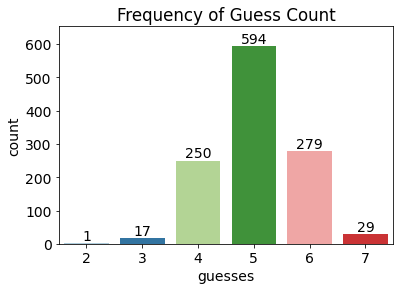

In [13]:
# I make a count plot to visualize how well the algorithm performs:

valid_patterns = all_patterns[all_patterns['is_valid']]

plt.rcParams.update({'font.size': 14})
ax = sns.countplot(x=valid_patterns.guesses, palette='Paired')
_ = ax.bar_label(ax.containers[0])
_ = ax.margins(y=0.1)
_ = plt.title("Frequency of Guess Count")
_ = plt.savefig('../results_mastermind.png', facecolor='white', bbox_inches='tight')

In [14]:
# The mean guess count:

round(np.mean(valid_patterns.guesses), 2)

5.04

In [15]:
# The total number of guesses for all patterns:

np.sum(valid_patterns.guesses)

# This is the number that I would use to compare my algorithm with others.
# There are many ways that I could improve my algorithm from here.
# I could adjust the ratio between the "position score" and the "color score."
# I could also try different patterns for the first guess.

5900

In [16]:
# A list of patterns guessed by the algorithm, not counting solution patterns:

patterns_guessed = all_patterns.query('times_guessed > 0')[['is_valid', 'times_guessed', 'score']]
patterns_guessed.sort_values('times_guessed', ascending=False)

# Only ~700 patterns are guessed out of the ~13,000 patterns in the pattern bank.

,is_valid,times_guessed,score
pattern,,,
rgby,True,1171,333.333333
ypgw,True,300,333.333333
bgwp,True,228,333.333333
yprg,True,136,333.333333
rpyb,True,132,333.333333
...,...,...,...
ppwy,True,2,266.666667
wgwy,True,2,266.666667
pprb,True,2,266.666667


<AxesSubplot:xlabel='score', ylabel='times_guessed'>

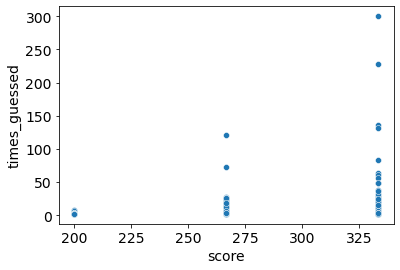

In [17]:
sns.scatterplot(x=patterns_guessed.iloc[1:].score, y=patterns_guessed.iloc[1:].times_guessed)

In [18]:
patterns_guessed.is_valid.value_counts()

True    475
Name: is_valid, dtype: int64